<center><b>Feature extraction per caratterizzazione stile di guida</b></center>

Ci occuperemo di estrarre dai dati valori di riferimento per caratterizzarne la guida di un pilota e di conseguenza riuscire a classficarlo. Comprenderanno velocità, accelerazioni, frenata (durata, intensità e trail-braking), traiettoria, marce ecc. 

First of all, let's import the computed data from *brakes_analysis.ipynb*

In [1]:
import pandas as pd  
#data of verstappen lap on suzuka
data = pd.read_pickle("data/merged_driverVER_lap1.pkl")
data.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,...,X,Y,Z,s_m,kappa,lat_acc_smooth,v_ms,lat_acc_est,in_curve_est,decel
0,2024-04-07 06:51:47.546,11013.0,281.0,7,100.0,False,12,car,0 days 00:00:00.392000,0 days 02:50:45.912000,...,188.4,-105.7,73.5,0.000000,0.0,0.0,78.055556,0.0,0,NaN
1,2024-04-07 06:51:47.706,11264.0,284.0,7,100.0,False,12,car,0 days 00:00:00.552000,0 days 02:50:46.072000,...,200.5,-120.2,73.0,0.000000,0.0,0.0,78.888889,0.0,0,-5.208333
2,2024-04-07 06:51:48.186,11528.0,289.0,7,100.0,False,12,car,0 days 00:00:01.032000,0 days 02:50:46.552000,...,215.1,-137.1,72.3,0.000000,0.0,0.0,80.277778,0.0,0,-2.893519
3,2024-04-07 06:51:48.385,11529.0,291.0,7,100.0,False,12,car,0 days 00:00:01.231000,0 days 02:50:46.751000,...,223.5,-146.9,72.0,19.915070,0.0,0.0,80.833333,0.0,0,-2.791736
4,2024-04-07 06:51:48.785,11438.0,294.0,7,100.0,False,12,car,0 days 00:00:01.631000,0 days 02:50:47.151000,...,259.6,-189.1,70.4,42.248229,0.0,0.0,81.666667,0.0,0,-2.083333


We want to produce a better vision on the brakes, not just 0-1 but a normalization of the values based on the telemetry. We can compare two methods: the first is *Decay smoothing*, the second is *rolling*

In [36]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.5  # velocità di smorzamento
brake_proxy = []
val = 0.0
for b in data['Brake']:
    if b == 1:
        val = 1.0
    else:
        val = val * (1-alpha)  # decadimento esponenziale
    brake_proxy.append(val)

data['brake_norm'] = brake_proxy

data['brake_norm'] = data['brake_norm']**0.7
  # rende più sensibile il segnale basso



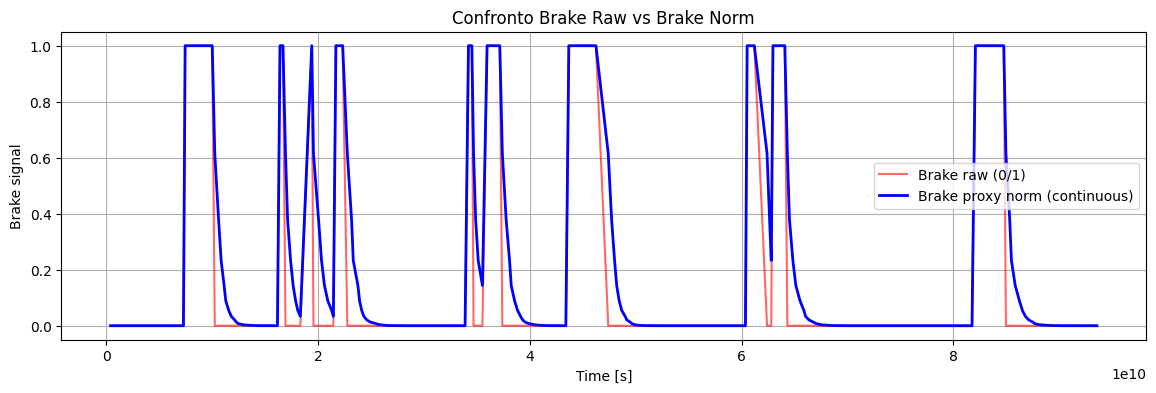

In [37]:
plt.figure(figsize=(14,4))
plt.plot(data['Time'], data['Brake'], label='Brake raw (0/1)', color='red', alpha=0.6)
plt.plot(data['Time'], data['brake_norm'], label='Brake proxy norm (continuous)', color='blue', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Brake signal')
plt.title('Confronto Brake Raw vs Brake Norm')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
inc = 0.2
dec = 0.2
val = 0.5
brake_proxy = []
for b in data['Brake']:
    if b == 1:
        val = min(val + inc, 1)
    else:
        val = max(val - dec, 0)
    brake_proxy.append(val)

data['brake_norm'] = brake_proxy
# --- opzionale: trasformazione non lineare per rendere più sensibile i valori bassi ---
data['brake_norm'] = data['brake_norm']**0.7


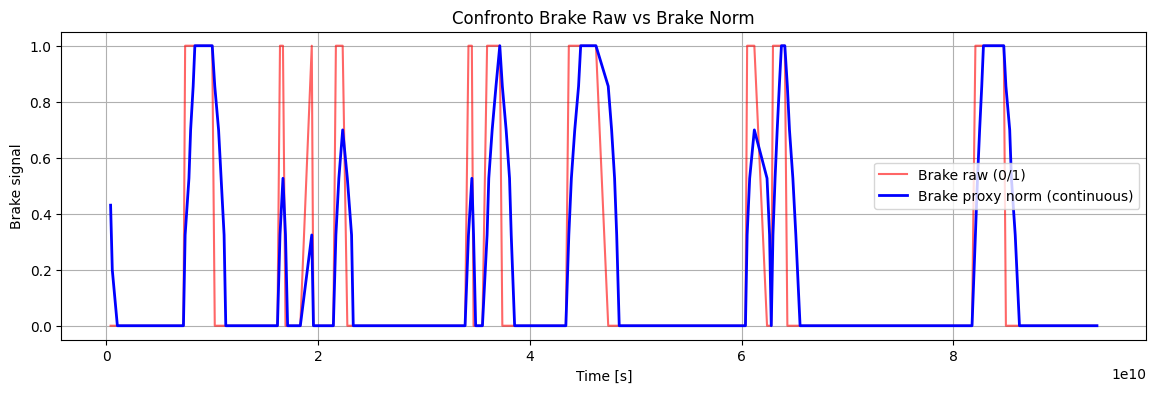

In [35]:
plt.figure(figsize=(14,4))
plt.plot(data['Time'], data['Brake'], label='Brake raw (0/1)', color='red', alpha=0.6)
plt.plot(data['Time'], data['brake_norm'], label='Brake proxy norm (continuous)', color='blue', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Brake signal')
plt.title('Confronto Brake Raw vs Brake Norm')
plt.legend()
plt.grid(True)
plt.show()

Feature per descrivere il ritmo del giro:
- *lap_time*: durata totale del giro
- *avg_speed*, *max_speed*: velocità media e massima
- *avg_throttle*, *pct_full_throttle*: media della quantità di gas applicato e percentuale di tempo full-gas
- *pct_braking_time*: tempo con brake > 0
- *avg_brake_intensity*: media di brake_proxy_norm 
- *n_brake_events*: numero di frenate distinte